## Step 0 — Reproducibility & setup
**Goal:** Make runs deterministic across Python/TensorFlow.
**Why:** Stable comparisons between model tweaks.
**Notes:** Determinism may be a bit slower on some ops; still worth it for experiments.


In [1]:
import os, random, numpy as np, tensorflow as tf

SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# optional: slightly stronger determinism (may slow a bit)
os.environ["TF_DETERMINISTIC_OPS"] = "1"
try:
    tf.config.experimental.enable_op_determinism(True)
except Exception as e:
    print("Determinism note:", e)

Determinism note: enable_op_determinism() takes 0 positional arguments but 1 was given


## Step 1 — Experiment config
**What:** Central place for ticker, dates, GRU size, seq length, LR, training schedule.
**Tip:** Only change here when running new experiments; everything else reads from `CFG`.


In [2]:
CFG = {
    "ticker": "BMW.DE",
    "start": "2010-01-01",
    "end":   "2025-06-01",
    "seq_len": 30,
    "units": 96,
    "dropout": 0.1,
    "lr": 5e-4,
    "batch": 32,
    "epochs": 100,
    "patience_es": 10,
    "patience_rlr": 5,
}


## Step 2 — Paths & artifacts
**What:** Resolve repo root and create `./artifacts/` for plots/metrics.
**Why:** Keep outputs organized & gitignored.


In [3]:
from pathlib import Path

def find_repo_root():
    p = Path.cwd()
    for parent in [p] + list(p.parents):
        if (parent / ".git").exists() or (parent / "README.md").exists():
            return parent
    return Path.cwd()

ROOT = find_repo_root()
ART = ROOT / "artifacts"
ART.mkdir(parents=True, exist_ok=True)
print("Artifacts ->", ART.resolve())

Artifacts -> C:\Users\LENOVO\tf_gpu\bmw_stock_prediction\artifacts


## Step 3 — Imports
**Rule:** Import all of the requried modules here for better pipeline.


In [4]:
import json
import yfinance as yf
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import root_mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras import layers, optimizers, callbacks, models

import matplotlib.pyplot as plt

## Step 4 — Data loading (with on-disk cache)
**Source:** Yahoo Finance (`yfinance`) for daily BMW.DE.
**Cache:** Saves to `data/bmw_raw.csv` to avoid repeated downloads.
**Output:** `df` (DateIndex) with columns: Open, High, Low, Close, Adj Close, Volume.


In [5]:
DATA = ROOT / "data"; DATA.mkdir(exist_ok=True, parents=True)
raw_csv = DATA / "bmw_raw.csv"

if raw_csv.exists():
    df = pd.read_csv(raw_csv, parse_dates=["Date"], index_col="Date")
else:
    df = yf.download(
        CFG["ticker"], start=CFG["start"], end=CFG["end"],
        auto_adjust=False, progress=False, group_by="column"
    )
    
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.droplevel(1)
    df.columns.name = None
    df = df.sort_index()
    
    out = df.copy()
    out.index.name = "Date"
    out.to_csv(raw_csv)

df.head()

,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2010-01-04,16.253130,32.049999,32.455002,31.820000,31.820000,1808170
2010-01-05,16.384983,32.310001,32.410000,31.785000,31.959999,1564182
2010-01-06,16.638542,32.810001,33.040001,32.360001,32.450001,2218604
2010-01-07,16.785604,33.099998,33.200001,32.380001,32.650002,2026145
2010-01-08,16.559938,32.654999,33.430000,32.514999,33.334999,1925894


## Step 5 — Feature engineering
**Target:** `Target_Adj_Close = AdjClose[t+1]`.
**Features:** returns, MA10/MA30, diff(AdjClose, MA10), 10-day volatility, 10-day momentum, lag1.
**Hygiene:** Replace ±inf→NaN, drop NaNs, reset index. Assert no missing values.


In [6]:
df_s = df.copy()

if "Volume" in df_s.columns:
    df_s = df_s[df_s["Volume"] > 0].copy()

df_s["Target_Adj_Close"] = df_s["Adj Close"].shift(-1)


adj = df_s["Adj Close"]
df_s["Return"]              = adj.pct_change()
df_s["MA_10"]               = adj.rolling(10, min_periods=10).mean()
df_s["MA_30"]               = adj.rolling(30, min_periods=30).mean()
df_s["AdjClose_MA_10_diff"] = adj - df_s["MA_10"]
df_s["Volatility_10"]       = df_s["Return"].rolling(10, min_periods=10).std()
df_s["Momentum_10"]         = adj - adj.shift(10)
df_s["AdjClose_lag1"]       = adj.shift(1)

df_s = df_s.replace([np.inf, -np.inf], np.nan).dropna().reset_index(drop=True)

features = df_s.drop(columns=["Target_Adj_Close"])
target   = df_s[["Target_Adj_Close"]]

(ART / "feature_list.txt").write_text("\n".join(features.columns))

assert not features.isna().any().any()
assert not target.isna().any().any()


## Step 6 — Split & scaling
**Split:** 70/15/15 in time order (no shuffling).
**Scaling:** MinMax on *features only* (fit on train).  
**Target for model:** next-day **delta** = Target_Adj_Close − AdjClose_lag1, scaled with **StandardScaler**.
**Why delta:** smaller, near-zero distribution → easier optimization, typically better generalization.


In [7]:
train_size = int(len(features) * 0.7)
val_size   = int(len(features) * 0.15)

train_features = features[:train_size]
val_features   = features[train_size:train_size + val_size]
test_features  = features[train_size + val_size:]

train_target = target[:train_size]
val_target   = target[train_size:train_size + val_size]
test_target  = target[train_size + val_size:]

print(f"Split sizes : train: {len(train_features)}, val: {len(val_features)}, test: {len(test_features)}")


feature_scaler = MinMaxScaler()
scaled_train_features = feature_scaler.fit_transform(train_features)
scaled_val_features   = feature_scaler.transform(val_features)
scaled_test_features  = feature_scaler.transform(test_features)


train_delta = (train_target["Target_Adj_Close"] - train_features["AdjClose_lag1"]).to_frame("Delta")
val_delta   = (val_target["Target_Adj_Close"]   - val_features["AdjClose_lag1"]).to_frame("Delta")
test_delta  = (test_target["Target_Adj_Close"]  - test_features["AdjClose_lag1"]).to_frame("Delta")

delta_scaler = StandardScaler()
ytr = delta_scaler.fit_transform(train_delta.values)
yva = delta_scaler.transform(val_delta.values)
yte = delta_scaler.transform(test_delta.values)


Split sizes : train: 2697, val: 577, test: 579


## Step 7 — Sequencing (rolling windows)
**What:** Build sequences of length `CFG['seq_len']` for X, aligned y at the end of each window.
**Output shapes:** (n_seq, seq_len, n_features) and (n_seq, 1).
**Leakage check:** Windows are built separately for train/val/test splits.


In [8]:
def make_seq(X, y, L):
    Xs, ys = [], []
    for i in range(L, len(X)):
        Xs.append(X[i-L:i])
        ys.append(y[i])
    return np.asarray(Xs, np.float32), np.asarray(ys, np.float32)


X_train, y_train = make_seq(scaled_train_features, ytr, CFG['seq_len'])
X_val,   y_val   = make_seq(scaled_val_features,   yva, CFG['seq_len'])
X_test,  y_test  = make_seq(scaled_test_features,  yte, CFG['seq_len'])

## Step 8 — Naive baseline (persistence)
**Definition:** Predict price[t] = price[t−1] (we already have `AdjClose_lag1`).
**Alignment:** Baseline uses the same indices as the sequenced targets.
**Metric:** RMSE on price (EUR).


In [9]:
def baseline_rmse(features_df, target_df, seq_len, split_name="split"):
    n = len(features_df)
    idx = np.arange(seq_len, n)  

    y_true  = target_df.iloc[idx].to_numpy().ravel()
    y_naive = features_df["AdjClose_lag1"].iloc[idx].to_numpy().ravel()

    mask = np.isfinite(y_true) & np.isfinite(y_naive)
    if mask.sum() < len(y_true):
        print(f"[{split_name}] Dropped {len(y_true) - mask.sum()} NaNs in baseline arrays.")

    return float(root_mean_squared_error(y_true[mask], y_naive[mask]))


## Step 9 — Model: GRU(96) → Dropout(0.1) → Dense(1)
**Why:** Simple, fast baseline that learns temporal patterns.
**Loss:** MSE on **delta**.
**Opt:** Adam (clipnorm=1.0) for stability.


In [10]:
model = models.Sequential([
    layers.GRU(CFG["units"], input_shape=(CFG['seq_len'], X_train.shape[2])),
    layers.Dropout(CFG["dropout"]),
    layers.Dense(1)
])
model.compile(
    optimizer=optimizers.Adam(learning_rate=CFG["lr"], clipnorm=1.0),
    loss="mse"
)
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 96)                31968     
                                                                 
 dropout (Dropout)           (None, 96)                0         
                                                                 
 dense (Dense)               (None, 1)                 97        
                                                                 
Total params: 32,065
Trainable params: 32,065
Non-trainable params: 0
_________________________________________________________________


## Step 10 — Callbacks
**EarlyStopping:** patience=10, restore best.
**ReduceLROnPlateau:** patience=5, factor=0.5.
**ModelCheckpoint:** saves best `.keras` by val loss.


In [11]:
cb = [
    callbacks.EarlyStopping(monitor="val_loss", patience=CFG["patience_es"], restore_best_weights=True),
    callbacks.ModelCheckpoint(filepath=str(ART / "best_gru_bmw_model.keras"),
                              monitor="val_loss", save_best_only=True),
    callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=CFG["patience_rlr"], verbose=1),
]


## Step 11 — Train
**Data:** (X_train, y_train) with val split for early stopping & LR schedule.
**Watch:** `val_loss` plateau; best epoch is marked in loss plots.


In [12]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=CFG['epochs'],
    batch_size=CFG['batch'],
    callbacks=cb,
    verbose=1
)

Epoch 1/100
84/84 [==============================] - 5s 12ms/step - loss: 1.0155 - val_loss: 2.1854 - lr: 5.0000e-04
Epoch 2/100
84/84 [==============================] - 1s 8ms/step - loss: 1.0208 - val_loss: 2.2130 - lr: 5.0000e-04
Epoch 3/100
84/84 [==============================] - 1s 8ms/step - loss: 1.0151 - val_loss: 2.1945 - lr: 5.0000e-04
Epoch 4/100
84/84 [==============================] - 1s 8ms/step - loss: 1.0131 - val_loss: 2.1861 - lr: 5.0000e-04
Epoch 5/100
84/84 [==============================] - 1s 8ms/step - loss: 1.0079 - val_loss: 2.2121 - lr: 5.0000e-04
Epoch 6/100
79/84 [===========================>..] - ETA: 0s - loss: 1.0207
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
84/84 [==============================] - 1s 8ms/step - loss: 1.0138 - val_loss: 2.1910 - lr: 5.0000e-04
Epoch 7/100
84/84 [==============================] - 1s 8ms/step - loss: 1.0075 - val_loss: 2.2035 - lr: 2.5000e-04
Epoch 8/100
84/84 [============================

## Step 12 — Loss plots
**Log-scale:** see small improvements near convergence.
**Smoothed:** 7-epoch rolling mean for readability.
**Artifacts:** `loss_curve_log.png`, `loss_curve_smooth.png`.


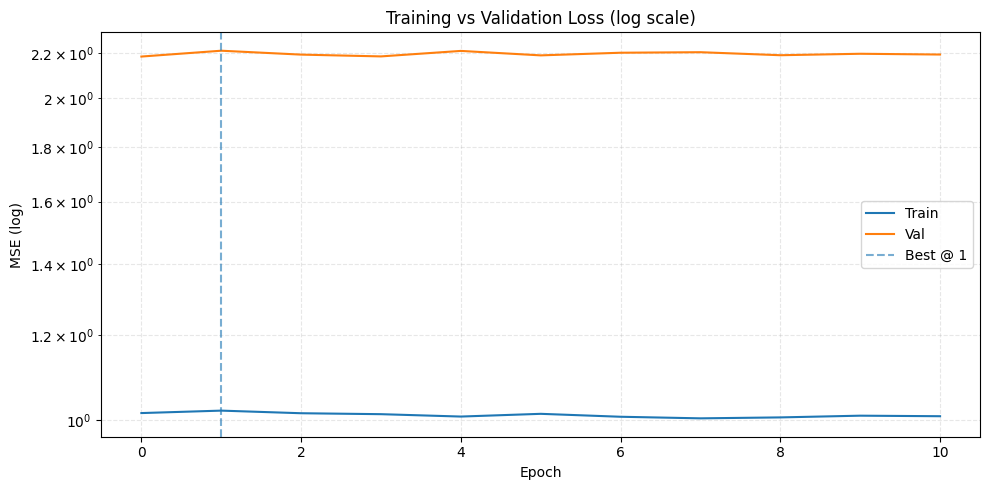

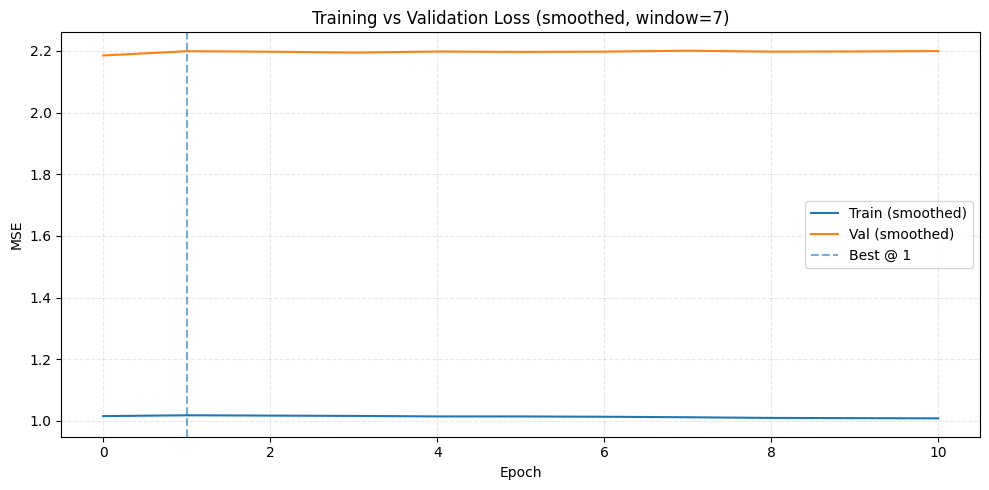

In [ ]:
loss = history.history.get("loss", [])
val_loss = history.history.get("val_loss", [])

if not loss:
    raise RuntimeError("No 'loss' in history.")

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(loss, label="Train")
if val_loss:
    ax.plot(val_loss, label="Val")
    best_epoch = int(np.argmin(val_loss)) + 1
    ax.axvline(best_epoch, linestyle="--", alpha=0.6, label=f"Best @ {best_epoch}")
ax.set_yscale("log")
ax.set_xlabel("Epoch"); ax.set_ylabel("MSE (log)")
ax.set_title("Training vs Validation Loss (log scale)")
ax.grid(True, which="both", ls="--", alpha=0.3); ax.legend(); fig.tight_layout()
fig.savefig(ART / "loss_curve_log.png", dpi=150); plt.show()

loss_s  = pd.Series(loss).rolling(window=7, min_periods=1).mean().values
vloss_s = pd.Series(val_loss).rolling(window=7, min_periods=1).mean().values if val_loss else None

fig2, ax2 = plt.subplots(figsize=(10,5))
ax2.plot(loss_s, label="Train (smoothed)")
if vloss_s is not None:
    ax2.plot(vloss_s, label="Val (smoothed)")
    ax2.axvline(best_epoch, linestyle="--", alpha=0.6, label=f"Best @ {best_epoch}")
ax2.set_xlabel("Epoch"); ax2.set_ylabel("MSE")
ax2.set_title("Training vs Validation Loss (smoothed, window=7)")
ax2.grid(True, ls="--", alpha=0.3); ax2.legend(); fig2.tight_layout()
fig2.savefig(ART / "loss_curve_smooth.png", dpi=150); plt.show()


## Steps 13–14 — Evaluation (Validation & Test, delta → price)

**Goal:** Assess generalization on both **validation** and **test** splits using the same, leak-free procedure.

**How we evaluate (identical for VAL & TEST):**
1. **Predict DELTA** with the trained GRU on `X_val` / `X_test`.
2. **Invert the delta scaling** with `delta_scaler.inverse_transform(...)` to get Δ in EUR.
3. **Reconstruct PRICE** by adding yesterday’s price:  
   `price_pred[t] = AdjClose_lag1[t] + delta_pred[t]`.
4. **Align indices** to the sequence targets (`seq_len … end-1`) so predictions, truths, and baseline line up.
5. **Compare to a naive baseline (persistence):**  
   `baseline_pred[t] = AdjClose_lag1[t] = price[t-1]`.
6. **Report metrics** on price (EUR): **RMSE** and **R²**, plus % improvement over the naive baseline.

**Outputs:**
- Printed metrics for **VAL** and **TEST**:  
  `VAL RMSE/R² (vs naive)` and `TEST RMSE/R² (vs naive)`.
- Plots (first ~300 points for readability):  
  - `artifacts/val_actual_vs_pred.png`  
  - `artifacts/test_actual_vs_pred.png`
- Loss curves for training reference:  
  - `artifacts/loss_curve_log.png`  
  - `artifacts/loss_curve_smooth.png`

**Notes & pitfalls (important):**
- We **train on delta** (zero-centered) and **evaluate on price** after reconstruction.  
  ➜ Do **not** use a MinMax **price** scaler to invert deltas; only use `delta_scaler`.
- The **baseline** must use the **same aligned indices** as the sequence targets; otherwise RMSE is misleading.
- No refitting on VAL/TEST: reuse the **train-fitted** feature scaler, delta scaler, and model weights.
- (Optional) Add residual diagnostics and predicted-vs-actual scatter if you want calibration checks.


In [14]:
def eval_split(X_seq, y_seq, features_df, target_df, seq_len, name="VAL"):
    idx = np.arange(seq_len, len(features_df))
    rmse_naive = baseline_rmse(features_df, target_df, seq_len, split_name=name)
    pred_delta = model.predict(X_seq, verbose=0)
    pred_delta_inv = delta_scaler.inverse_transform(pred_delta)
    lag1 = features_df["AdjClose_lag1"].iloc[idx].to_numpy().reshape(-1, 1)
    pred_price = lag1 + pred_delta_inv
    true_price = target_df.iloc[idx].to_numpy()
    rmse = float(root_mean_squared_error(true_price, pred_price))
    r2   = float(r2_score(true_price, pred_price))
    return rmse_naive, rmse, r2, true_price, pred_price


In [19]:
val_rmse_naive, val_rmse, val_r2, y_val_price_true, val_pred_price = eval_split(
    X_val, y_val, val_features, val_target, CFG['seq_len'], name="VAL"
)
print(f"VAL  RMSE: {val_rmse:.4f} (naive {val_rmse_naive:.4f}) | R²: {val_r2:.4f}")

test_rmse_naive, test_rmse, test_r2, y_test_price_true, test_pred_price = eval_split(
    X_test, y_test, test_features, test_target, CFG['seq_len'], name="TEST"
)
print(f"TEST RMSE: {test_rmse:.4f} (naive {test_rmse_naive:.4f}) | R²: {test_r2:.4f}")

val_improve  = 100 * (1 - val_rmse  / max(val_rmse_naive, 1e-12))
test_improve = 100 * (1 - test_rmse / max(test_rmse_naive, 1e-12))

summary = {
    "seq_len": CFG["seq_len"],
    "units": CFG["units"],
    "dropout": CFG["dropout"],
    "lr": CFG["lr"],
    "batch": CFG["batch"],
    "epochs": CFG["epochs"],
    "val_rmse_naive": round(val_rmse_naive, 4),
    "val_rmse_model": round(val_rmse, 4),
    "val_r2": round(val_r2, 4),
    "val_improve_%": round(val_improve, 2),
    "test_rmse_naive": round(test_rmse_naive, 4),
    "test_rmse_model": round(test_rmse, 4),
    "test_r2": round(test_r2, 4),
    "test_improve_%": round(test_improve, 2),
}

VAL  RMSE: 1.6077 (naive 1.6109) | R²: 0.9256
TEST RMSE: 1.9322 (naive 1.9328) | R²: 0.9567


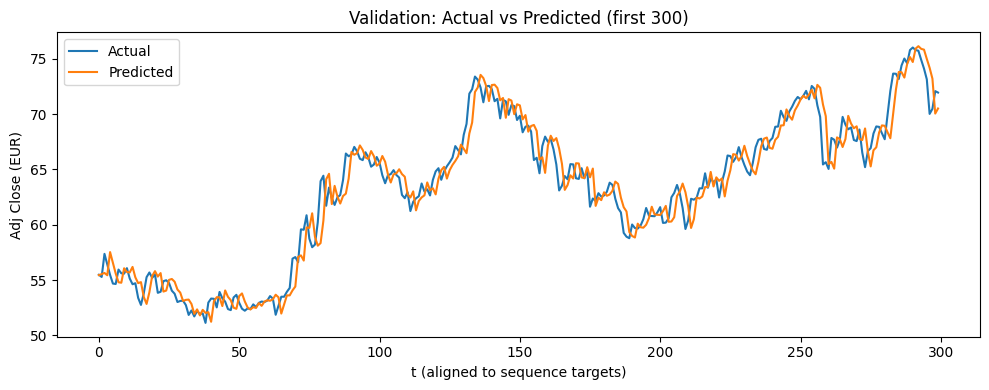

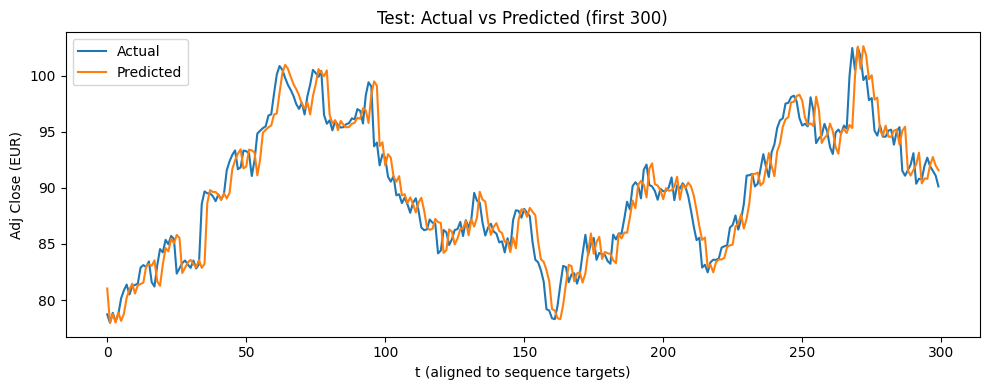

In [16]:
plt.figure(figsize=(10,4))
plt.plot(y_val_price_true[:300], label="Actual")
plt.plot(val_pred_price[:300],   label="Predicted")
plt.title("Validation: Actual vs Predicted (first 300)")
plt.xlabel("t (aligned to sequence targets)"); plt.ylabel("Adj Close (EUR)")
plt.legend(); plt.tight_layout()
plt.savefig(ART / "val_actual_vs_pred.png", dpi=150); plt.show()

plt.figure(figsize=(10,4))
plt.plot(y_test_price_true[:300], label="Actual")
plt.plot(test_pred_price[:300],   label="Predicted")
plt.title("Test: Actual vs Predicted (first 300)")
plt.xlabel("t (aligned to sequence targets)"); plt.ylabel("Adj Close (EUR)")
plt.legend(); plt.tight_layout()
plt.savefig(ART / "test_actual_vs_pred.png", dpi=150); plt.show()


## Step 15 — Save run metadata
**Files:** `metrics.json` (final numbers), `config.json` (CFG), `env.json` (library versions).
**Why:** Reproducibility across machines and commits.


In [18]:
env = {
    "tensorflow": tf.__version__,
    "pandas": pd.__version__,
    "sklearn":  __import__("sklearn").__version__,
    "numpy": np.__version__,
}
with open(ART / "env.json", "w") as f: json.dump(env, f, indent=2)
with open(ART / "config.json", "w") as f: json.dump(CFG, f, indent=2)
with open(ART / "metrics.json", "w") as f: json.dump(summary, f, indent=2)
